In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "5"

In [4]:
import torch
from torch import nn
from torch.nn import functional as F

# create residual block and residual stack according to 4.1
class ResidualBlock(nn.Module):
    def __init__(self, num_hiddens, num_residual_hiddens):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channels=num_hiddens, out_channels=num_residual_hiddens, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_residual_hiddens, out_channels=num_hiddens, kernel_size=1),
        )

    def forward(self, x):
        return x + self.block(x)

class ResidualStack(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self.blocks = nn.ModuleList([ResidualBlock(num_hiddens, num_residual_hiddens) for _ in range(num_residual_layers)])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return F.relu(x)

# 4.1 Encoder 
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_downsampling_layers, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()
        conv = nn.Sequential()
        for downsampling_layer in range(num_downsampling_layers):
            if downsampling_layer == 0: 
                # (3,64)
                out_channels = num_hiddens // 2  
            elif downsampling_layer == 1:
                # (64,128)
                (in_channels, out_channels) = (num_hiddens // 2, num_hiddens)
            else:
                # (128,128)
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            conv.add_module(
                f"down{downsampling_layer}",
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2,padding=1),
            )
            conv.add_module(f"relu{downsampling_layer}", nn.ReLU())

        conv.add_module(
            "final_conv",
            nn.Conv2d(in_channels=num_hiddens,out_channels=num_hiddens,kernel_size=3,padding=1),
        )
        self.conv = conv
        # residual: Relu -> (128,32) -> Relu -> (32, 128)
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )

    def forward(self, x):
        h = self.conv(x)
        return self.residual_stack(h)

# 4.1 Decoder 
class Decoder(nn.Module):
    def __init__(self, embedding_dim, num_hiddens, num_upsampling_layers, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=embedding_dim,
            out_channels=num_hiddens,
            kernel_size=3,
            padding=1,
        )
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )
        upconv = nn.Sequential()
        for upsampling_layer in range(num_upsampling_layers):
            if upsampling_layer < num_upsampling_layers - 2:
                # (128, 128)
                (in_channels, out_channels) = (num_hiddens, num_hiddens)
            elif upsampling_layer == num_upsampling_layers - 2:
                # (128, 64)
                (in_channels, out_channels) = (num_hiddens, num_hiddens // 2)
            else:
                # (64, 3)
                (in_channels, out_channels) = (num_hiddens // 2, 3)

            upconv.add_module(
                f"up{upsampling_layer}",
                nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1),
            )
            if upsampling_layer < num_upsampling_layers - 1:
                upconv.add_module(f"relu{upsampling_layer}", nn.ReLU())

        self.upconv = upconv

    def forward(self, x):
        h = self.conv(x)
        h = self.residual_stack(h)
        x_recon = self.upconv(h)
        return x_recon


 # Implement Appendix A.1
class SonnetExponentialMovingAverage(nn.Module):
    def __init__(self, decay, shape):
        super().__init__()
        self.decay = decay
        self.counter = 0
        self.register_buffer("hidden", torch.zeros(*shape))
        self.register_buffer("average", torch.zeros(*shape))

    def update(self, value):
        self.counter += 1
        with torch.no_grad():
            self.hidden -= (self.hidden - value) * (1 - self.decay)
            self.average = self.hidden / (1 - self.decay ** self.counter)

    def __call__(self, value):
        self.update(value)
        return self.average

# https://github.com/google-deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py
# This is from DeepMind, tensorflow version
class VectorQuantizer(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, use_ema, decay, epsilon):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.use_ema = use_ema
        self.decay = decay
        self.epsilon = epsilon
        limit = 3 ** 0.5

        e_i_ts = torch.FloatTensor(embedding_dim, num_embeddings).uniform_(
            -limit, limit
        )
        if use_ema:
            self.register_buffer("e_i_ts", e_i_ts)
        else:
            self.register_parameter("e_i_ts", nn.Parameter(e_i_ts))

        self.N_i_ts = SonnetExponentialMovingAverage(decay, (num_embeddings,))
        self.m_i_ts = SonnetExponentialMovingAverage(decay, e_i_ts.shape)

    def forward(self, x):
        flat_x = x.permute(0, 2, 3, 1).reshape(-1, self.embedding_dim)
        distances = (
            (flat_x ** 2).sum(1, keepdim=True)
            - 2 * flat_x @ self.e_i_ts
            + (self.e_i_ts ** 2).sum(0, keepdim=True)
        )
        encoding_indices = distances.argmin(1)
        quantized_x = F.embedding(
            encoding_indices.view(x.shape[0], *x.shape[2:]), self.e_i_ts.transpose(0, 1)
        ).permute(0, 3, 1, 2)

        # See second term of Equation (3).
        if not self.use_ema:
            dictionary_loss = ((x.detach() - quantized_x) ** 2).mean()
        else:
            dictionary_loss = None

        # encoder commits to an embedding with its output not growing
        commitment_loss = ((x - quantized_x.detach()) ** 2).mean()
        # freeze 
        quantized_x = x + (quantized_x - x).detach()

        if self.use_ema and self.training:
            with torch.no_grad():
                encoding_one_hots = F.one_hot(encoding_indices, self.num_embeddings).type(flat_x.dtype)
                n_i_ts = encoding_one_hots.sum(0)
                # Update
                self.N_i_ts(n_i_ts)
                # Moving average 
                embed_sums = flat_x.transpose(0, 1) @ encoding_one_hots
                self.m_i_ts(embed_sums)

                N_i_ts_sum = self.N_i_ts.average.sum()
                N_i_ts_stable = (
                    (self.N_i_ts.average + self.epsilon) / (N_i_ts_sum + self.num_embeddings * self.epsilon) * N_i_ts_sum
                )
                self.e_i_ts = self.m_i_ts.average / N_i_ts_stable.unsqueeze(0)

        return (
            quantized_x, dictionary_loss, commitment_loss, encoding_indices.view(x.shape[0], -1),
        )


class VQVAE(nn.Module):
    def __init__(self,in_channels,num_hiddens,num_downsampling_layers,num_residual_layers,num_residual_hiddens,
                 embedding_dim,num_embeddings,use_ema,decay,epsilon):
        super().__init__()
        self.encoder = Encoder(
            in_channels,num_hiddens,num_downsampling_layers,num_residual_layers,num_residual_hiddens
            )
        self.pre_vq_conv = nn.Conv2d(
            in_channels=num_hiddens, out_channels=embedding_dim, kernel_size=1
        )
        self.vq = VectorQuantizer(
            embedding_dim, num_embeddings, use_ema, decay, epsilon
        )
        self.decoder = Decoder(
            embedding_dim,num_hiddens,num_downsampling_layers,num_residual_layers,num_residual_hiddens,
        )

    def quantize(self, x):
        z = self.pre_vq_conv(self.encoder(x))
        (z_quantized, dictionary_loss, commitment_loss, encoding_indices) = self.vq(z)
        return (z_quantized, dictionary_loss, commitment_loss, encoding_indices)

    def forward(self, x):
        (z_quantized, dictionary_loss, commitment_loss, _) = self.quantize(x)
        x_recon = self.decoder(z_quantized)
        return {"dictionary_loss": dictionary_loss, "commitment_loss": commitment_loss, "x_recon": x_recon}


In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10

# Model Configuration
device = torch.device("cuda:0")
use_ema = True
model_args = {
    "in_channels": 3, "num_hiddens": 128, "num_downsampling_layers": 2, "num_residual_layers": 2,
    "num_residual_hiddens": 32, "embedding_dim": 64, "num_embeddings": 512,
    "use_ema": True, "decay": 0.99, "epsilon": 1e-5,
}
model = VQVAE(**model_args).to(device)

batch_size = 32
workers = 10
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[1.0, 1.0, 1.0]),]
    )
data_root = "./data"

train_dataset = CIFAR10(data_root, True, transform, download=True)
train_data_variance = np.var(train_dataset.data / 255)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)


beta = 0.25
train_params = [params for params in model.parameters()]
lr = 0.0005
optimizer = optim.Adam(train_params, lr=lr)
criterion = nn.MSELoss()

# Training
epochs = 40
eval_every = 32
total_train = 50000
loss_list = []
recon_loss_list = []

model.train()
for epoch in range(epochs):
    total_train_loss = 0
    total_recon_error = 0
    for batch_idx, train_tensors in enumerate(train_loader):
        optimizer.zero_grad()
        imgs = train_tensors[0].to(device)
        out = model(imgs)

        recon_error = criterion(out["x_recon"], imgs) / train_data_variance
        total_recon_error += recon_error.item()

        loss = recon_error + beta * out["commitment_loss"]

        if not use_ema:
            loss += out["dictionary_loss"]

        total_train_loss += loss.item()

        loss.backward()

        optimizer.step()

    loss_list.append(total_train_loss/total_train*batch_size)
    recon_loss_list.append(total_recon_error/total_train*batch_size)
    print(f'Epoch {epoch + 1}/{epochs}, '
          f'Total Training Loss: {total_train_loss / total_train*batch_size:.4f}, '
          f'Reconstruction Loss: {total_recon_error/total_train*batch_size:.4f}, ')

Files already downloaded and verified
Epoch 1/40, Total Training Loss: 0.1882, Reconstruction Loss: 0.1591, 
Epoch 2/40, Total Training Loss: 0.1084, Reconstruction Loss: 0.0769, 
Epoch 3/40, Total Training Loss: 0.0982, Reconstruction Loss: 0.0652, 
Epoch 4/40, Total Training Loss: 0.0947, Reconstruction Loss: 0.0603, 
Epoch 5/40, Total Training Loss: 0.0934, Reconstruction Loss: 0.0585, 
Epoch 6/40, Total Training Loss: 0.0922, Reconstruction Loss: 0.0573, 
Epoch 7/40, Total Training Loss: 0.0913, Reconstruction Loss: 0.0565, 
Epoch 8/40, Total Training Loss: 0.0906, Reconstruction Loss: 0.0561, 
Epoch 9/40, Total Training Loss: 0.0899, Reconstruction Loss: 0.0555, 
Epoch 10/40, Total Training Loss: 0.0894, Reconstruction Loss: 0.0554, 
Epoch 11/40, Total Training Loss: 0.0888, Reconstruction Loss: 0.0549, 
Epoch 12/40, Total Training Loss: 0.0883, Reconstruction Loss: 0.0544, 
Epoch 13/40, Total Training Loss: 0.0880, Reconstruction Loss: 0.0542, 
Epoch 14/40, Total Training Loss: 0

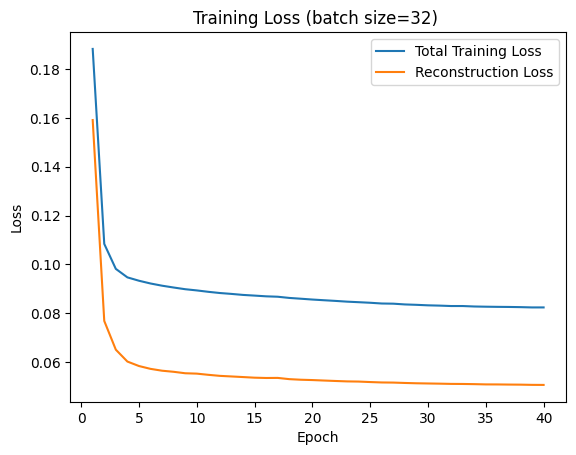

In [9]:
# Plot and save the epoch losses
plt.plot(range(1, epochs + 1), loss_list, label='Total Training Loss')
plt.plot(range(1, epochs + 1), recon_loss_list, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (batch size=32) ')
plt.legend()
plt.savefig('loss_plot-batchsize-32.png')

In [10]:
def save_img_tensors_as_grid(img_tensors, nrows, f):
    img_tensors = torch.clamp(img_tensors, -0.5, 0.5)
    img_tensors = (img_tensors + 0.5) * 255
    img_tensors = img_tensors.to(torch.uint8)
    
    batch_size, _, img_size, _ = img_tensors.shape
    ncols = batch_size // nrows

    img_grid = torch.zeros((3, 2 * img_size, 16 * img_size), dtype=torch.uint8)

    for idx in range(batch_size):
        row_idx = idx // ncols
        col_idx = idx % ncols
        if row_idx <2 and col_idx <16:
            row_start = row_idx * img_size
            row_end = row_start + img_size
            col_start = col_idx * img_size
            col_end = col_start + img_size

            img_grid[:, row_start:row_end, col_start:col_end] = img_tensors[idx]

    img_grid = transforms.ToPILImage()(img_grid)
    img_grid.save(f"{f}.jpg")

# Reconstruction Visualization
model.eval()

test_dataset = CIFAR10(data_root, False, transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=workers)

with torch.no_grad():
    for img in test_loader:
        break
    save_img_tensors_as_grid(model(img[0].to(device))["x_recon"], 2, "recon-batchsize-32")


Files already downloaded and verified


In [8]:
import scipy
import skimage
from torchvision.utils import save_image
from torchvision.utils import make_grid
from skimage.metrics import structural_similarity as ssim
from scipy.stats import entropy
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
from torch.nn.functional import interpolate

print(scipy.__version__)
print(skimage.__version__)

def evaluate_model(model, dataloader, device):
    model.eval()

    # Lists to store generated and real images
    generated_images = []
    real_images = []

    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader):
            inputs, _ = data
            inputs = inputs.to(device)

            # Generate images
            outputs = model(inputs)["x_recon"]
            
            # Append generated and real images to lists
            generated_images.append(outputs.cpu())
            real_images.append(inputs.cpu())

    generated_images = torch.cat(generated_images, dim=0)
    real_images = torch.cat(real_images, dim=0)

    # Normalize images to [0, 1] range
    real_images_normalized = real_images + 0.5
    generated_images_normalized = generated_images + 0.5

    # Calculate SSIM
    ssim_value = ssim(
    real_images_normalized.numpy(),
    generated_images_normalized.numpy(),
    multichannel=True,  # Set to True if your images have multiple channels (e.g., RGB)
    win_size=7,         # Set an odd value less than or equal to the smaller side of your images
    channel_axis=1,    # Set to 1 for PyTorch format (channels are the second axis)
    data_range=1.0
)
    # Calculate Inception Score
    # inception_score = calculate_inception_score(generated_images, device)
    # Print or log the results
    print(f'SSIM: {ssim_value:.4f}')

          
def calculate_inception_score(images, device):
    # Load InceptionV3 model
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device).eval()

    # Resize images to InceptionV3 input size
    images_resized = interpolate(images, size=(299, 299), mode='bilinear', align_corners=False).to(device)

    # Forward pass through InceptionV3
    with torch.no_grad():
        logits = inception_model(images_resized)

    # Calculate Inception Score
    preds = torch.nn.functional.softmax(logits, dim=1).numpy()
    kl_divergences = [entropy(p, q) for p, q in zip(preds, preds.mean(axis=0))]
    inception_score = np.exp(np.mean(kl_divergences))

    return inception_score

# Call the evaluation function
evaluate_model(model, train_loader, device)


1.10.1
0.21.0


SSIM: 0.9631
